In [1]:
import numpy as np
import stim
import pymatching as pm
import pandas as pd
import time
from tqdm import tqdm
from src.utils import det_to_coords
from src.decoders.window_decoder import ParallelDecoder
from src.noise import NoiseModel

r=4

# r = 0, shots = 2_000
# r = 1, shots = 10_000
# r = 2, shots = 50_000
# r = 3, shots = 1_000
# r = 4, shots = 2_000, T = rounds
# r = 5, shots = 1_000, T = rounds, mode = "streaming" [BROKEN]

ModuleNotFoundError: No module named 'src'

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot(data: pd.DataFrame, shots: int = 2000):
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.3)
    
    ax_main = fig.add_subplot(gs[0])
    ax_diff = fig.add_subplot(gs[1], sharex=ax_main)
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(data['lattice_size'].unique())))
    
    # Main
    for idx, size in enumerate(sorted(data['lattice_size'].unique())):
        global_subset = data[(data['lattice_size'] == size) & (data['type'] == 'global')]
        window_subset = data[(data['lattice_size'] == size) & (data['type'] == 'parallel')]
        
        # error bars from pymatching tutorial.
        global_err = np.sqrt(global_subset['logical_error_rate'] * 
                            (1 - global_subset['logical_error_rate']) / shots)
        window_err = np.sqrt(window_subset['logical_error_rate'] * 
                            (1 - window_subset['logical_error_rate']) / shots)
        
        # lower / upper
        y1 = global_subset['logical_error_rate'] - global_err
        y2 = global_subset['logical_error_rate'] + global_err

        # global plots
        ax_main.fill_between(
            global_subset['rounds'],
            y1,
            y2,
            alpha=0.2,
            color=colors[idx]
        )

        ax_main.plot(
            global_subset['rounds'],
            global_subset['logical_error_rate'],
            linestyle='-',
            color=colors[idx],
            label=f'Global L={size}',
            alpha=0.5
        )

        # parallel plots
        ax_main.errorbar(
            window_subset['rounds'],
            window_subset['logical_error_rate'],
            yerr=window_err,
            fmt='.',
            color=colors[idx],
            label=f'Parallel L={size}',
            markeredgewidth=1.5,
            capsize=3,
            alpha=0.5
        )
        
        # Difference plot: (Sliding - Global) / Global * 100 for percentage
        # Align data by rounds
        merged = pd.merge(
            global_subset[['rounds', 'logical_error_rate']],
            window_subset[['rounds', 'logical_error_rate']],
            on='rounds',
            suffixes=('_global', '_parallel')
        )
        
        # compute rel. percentage difference
        rel_diff = ((merged['logical_error_rate_parallel'] - merged['logical_error_rate_global']) 
                    / merged['logical_error_rate_global'] * 100)
        
        ax_diff.plot(
            merged['rounds'],
            rel_diff,
            marker='D',
            linestyle='-',
            color=colors[idx],
            label=f'L={size}',
            markersize=5,
            linewidth=2,
            alpha=0.8
        )
    
    # main formatting
    ax_main.set_ylabel('Logical Error Rate', fontsize=13, fontweight='bold')
    ax_main.set_ylim(1e-4, 1e-0)
    ax_main.set_xlim(25, 230)
    ax_main.set_yscale('log')
    ax_main.legend(loc='best', fontsize=9, ncol=2, framealpha=0.9)
    ax_main.grid(True, alpha=0.3, which='both', linestyle=':', linewidth=0.7)
    ax_main.set_title('Logical Error Rate: Global vs Parallel Window Decoder', 
                     fontsize=14, fontweight='bold', pad=15)
    plt.setp(ax_main.get_xticklabels(), visible=False)
    
    # rel. difference formatting
    ax_diff.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax_diff.set_xlabel('Rounds', fontsize=13, fontweight='bold')
    ax_diff.set_ylabel('Relative Error\nDifference (%)', fontsize=11, fontweight='bold')
    ax_diff.set_xlim(0, 230)
    ax_diff.legend(loc='best', fontsize=9, ncol=4, framealpha=0.9)
    ax_diff.grid(True, alpha=0.3, linestyle=':', linewidth=0.7)
    ax_diff.set_title('Relative Difference: (Parallel - Global) / Global × 100%', 
                     fontsize=11, style='italic', pad=10)
    
    # shading for positive/negative regions
    ax_diff.axhspan(0, ax_diff.get_ylim()[1], alpha=0.1, color='red', zorder=-1)
    ax_diff.axhspan(ax_diff.get_ylim()[0], 0, alpha=0.1, color='green', zorder=-1)
    
    # plt.tight_layout()
    plt.show()
    return
    

In [ ]:

def run_parallel_decoder(circuit: stim.Circuit, dem: stim.DetectorErrorModel, syndrome, actual_observables, matching, d, shots, mode):
    
    n_buffer = n_commit = d

    window_decoder = ParallelDecoder((n_commit, n_buffer), circuit=circuit)
    
    parallel_syn = window_decoder.decode(syndrome=syndrome, mode=mode)
    
    global_preds = matching.decode_batch(syndrome)
    parallel_pred = matching.decode_batch(parallel_syn)

    ler_global = np.sum(np.any(global_preds != actual_observables, axis=1)) / shots
    ler_parallel = np.sum(np.any(parallel_pred != actual_observables, axis=1)) / shots

    return ler_global,ler_parallel


In [ ]:
r += 1
physical_error_rate = 0.02 # physical error rate of 2%
distances = [5, 7] #9, 11, 13, 15, 17]
rounds = np.linspace(25,225,10)
shots=50
correlated = False
mode="barrier"

data = []
columns = ['physical_error_rate','lattice_size','rounds','logical_error_rate','time','type']

noise_model = NoiseModel(
    after_clifford_depolarization=0.0, 
    after_reset_flip_probability=physical_error_rate, 
    before_measure_flip_probability=physical_error_rate, 
    before_round_data_depolarization=physical_error_rate
)

total = len(distances) * len(rounds)
with tqdm(total=total, desc=f"Simulating...") as pbar:
    for d in distances:
        print(f'Running L={d}x{d}...')
        for n in rounds:
            circuit = stim.Circuit.generated(
                "surface_code:rotated_memory_z",
                distance=d,
                rounds=int(n),
                # phenomological Pauli noise
                **noise_model.get_params()
            )

            dem = circuit.detector_error_model(decompose_errors=True)
            matching = pm.Matching.from_detector_error_model(dem)
            sampler = circuit.compile_detector_sampler()
            syndrome, actual_observables = sampler.sample(shots=shots, separate_observables=True)
            
            start = time.perf_counter()
            ler_global, ler_parallel = run_parallel_decoder(circuit, dem, np.copy(syndrome), actual_observables, matching, d, shots, mode)
            elapsed = time.perf_counter() - start

            data.append([physical_error_rate,d,n,ler_global,elapsed,'global'])
            data.append([physical_error_rate,d,n,ler_parallel,elapsed,'parallel'])
            pbar.update(1)
        
df = pd.DataFrame(data, columns=columns)
f = f'data/global_vs_parallel_{r}.csv'
df.to_csv(f)

Simulating...:   0%|          | 0/70 [00:00<?, ?it/s]

Simulating...:   7%|▋         | 5/70 [00:00<00:01, 39.96it/s]

Running L=5x5...


Simulating...:  21%|██▏       | 15/70 [00:00<00:02, 20.36it/s]

Running L=7x7...


Simulating...:  33%|███▎      | 23/70 [00:01<00:03, 14.90it/s]

Running L=9x9...


Simulating...:  47%|████▋     | 33/70 [00:02<00:04,  9.14it/s]

Running L=11x11...


Simulating...:  57%|█████▋    | 40/70 [00:04<00:07,  4.06it/s]

Running L=13x13...


Simulating...:  74%|███████▍  | 52/70 [00:06<00:04,  4.38it/s]

Running L=15x15...


Simulating...:  89%|████████▊ | 62/70 [00:10<00:02,  3.33it/s]

Running L=17x17...


Simulating...: 100%|██████████| 70/70 [00:14<00:00,  4.96it/s]


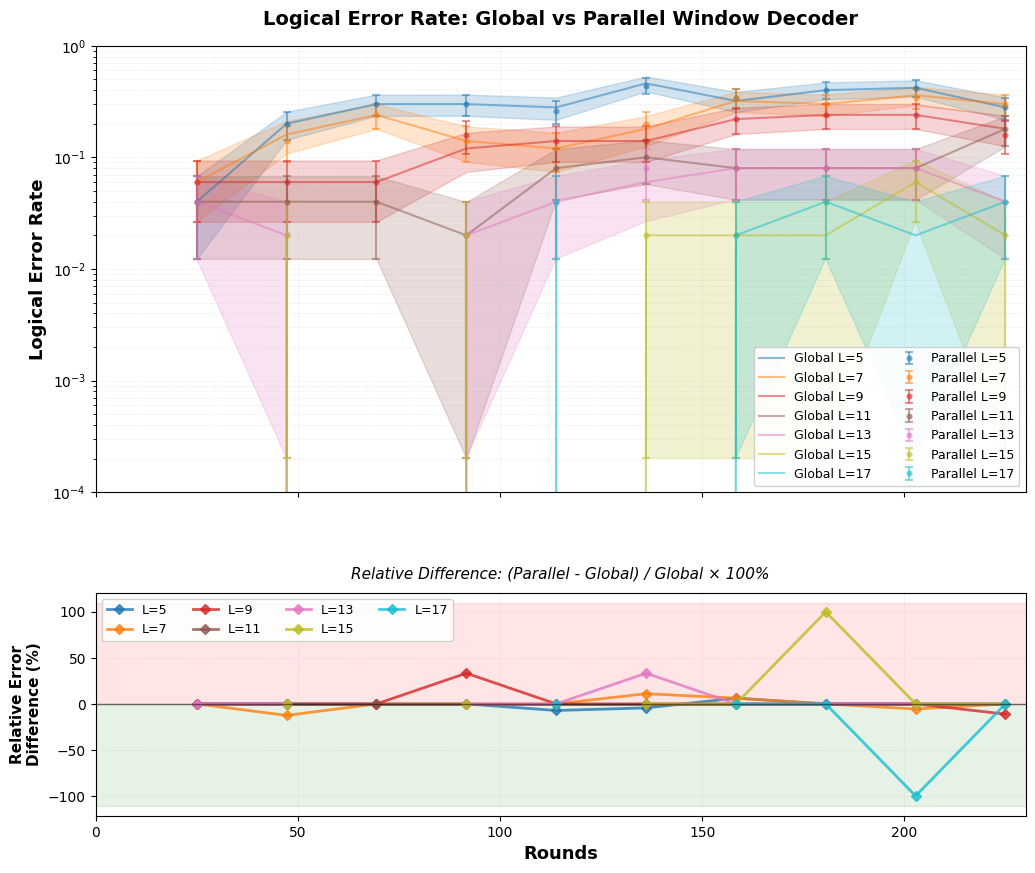

In [5]:
plot(df, shots)

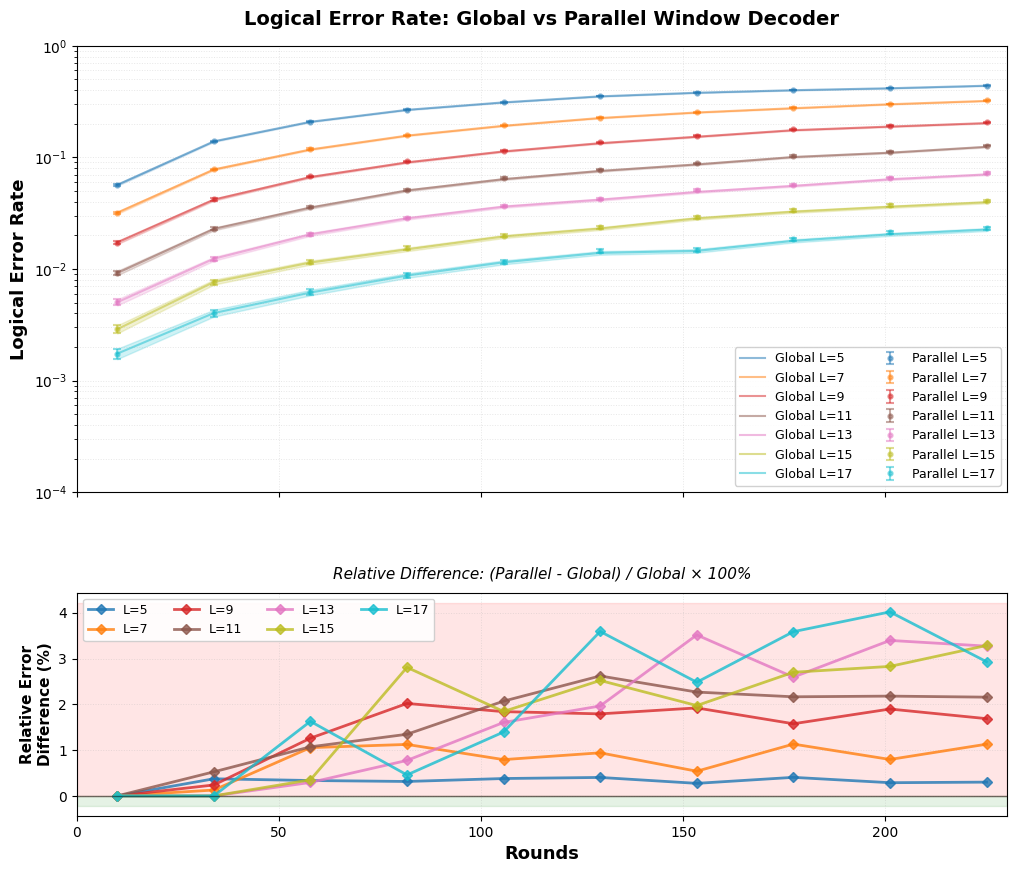

In [8]:
import pandas as pd

r0 = r'data/global_vs_parallel_0.csv'; shots0 = 2_000
r1 = r'data/global_vs_parallel_1.csv'; shots1 = 10_000 
r2 = r'data/global_vs_parallel_2.csv'; shots2 = 50_000
r3 = r'data/global_vs_parallel_3.csv'; shots3 = 1_000
r4 = r'data/global_vs_parallel_4.csv'; shots4 = 2_000

df = pd.read_csv(r2)
plot(df, shots2)

In [ ]:
import numpy as np
from src.utils import run_experiment
from src.utils import Parameters

df = run_experiment(Parameters(
    physical_error_rate = 0.02,
    distances = [5, 7, 11],
    rounds = np.linspace(25,225,10),
    shots=1_000
), n_buffer=3)

Simulating...:   0%|          | 0/30 [00:00<?, ?it/s]

Running L=5x5...


Simulating...:  37%|███▋      | 11/30 [00:06<00:12,  1.47it/s]

Running L=7x7...


Simulating...:  67%|██████▋   | 20/30 [00:15<00:13,  1.32s/it]

Running L=11x11...


Simulating...: 100%|██████████| 30/30 [00:35<00:00,  1.20s/it]


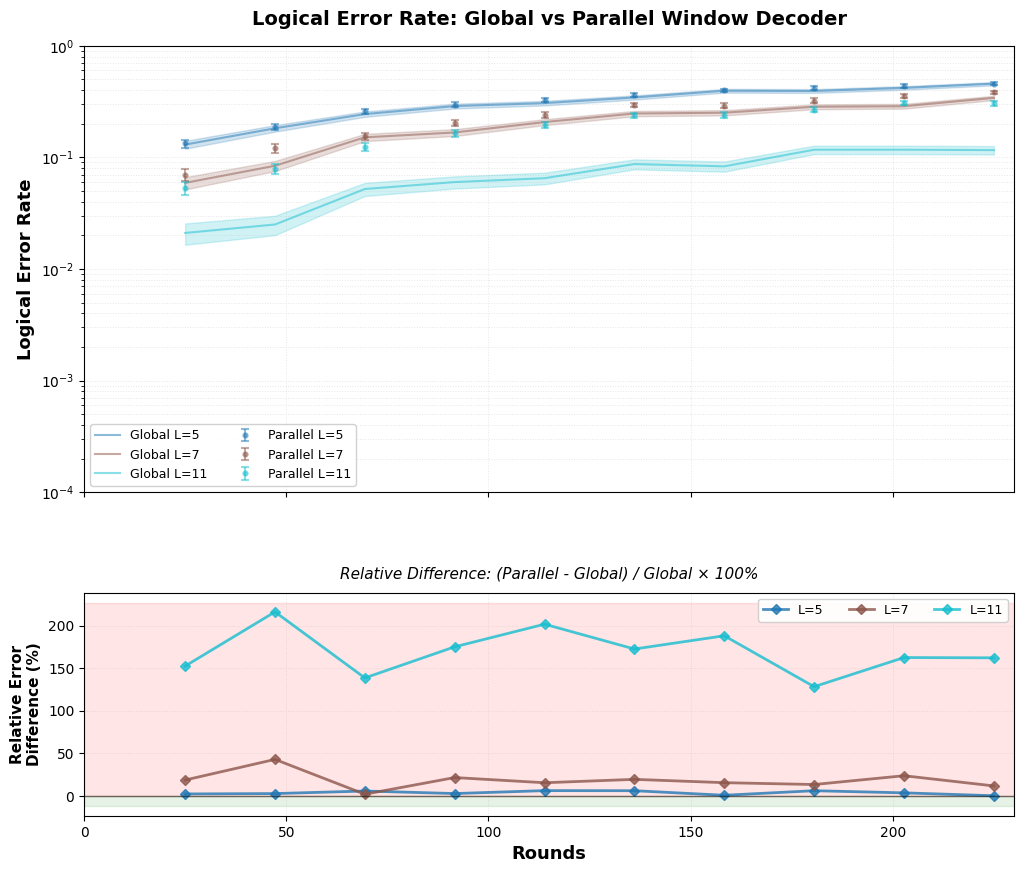

In [19]:
plot(df, 1_000)

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_ler_by_window(df):
    data = df.copy()

    # build ordered categorical labels for each window size
    data["window"] = data[["n_buffer", "n_commit"]].apply(tuple, axis=1)
    window_order = sorted(data["window"].unique(), key=lambda t: (t[0], t[1]))
    window_labels = [f"({a},{b})" for a, b in window_order]
    data["window_label"] = pd.Categorical(
        [f"({a},{b})" for a, b in data["window"]],
        categories=window_labels,
        ordered=True,
    )

    ax = sns.lineplot(
        data=data,
        x="window_label",
        y="logical_error_rate",
        hue="type",
        marker="o",
        linewidth=2,
        estimator="median",
        errorbar=None,
    )
    ax.set_xlabel("(n_buffer, n_commit)")
    ax.set_ylabel("logical_error_rate")
    ax.tick_params(axis="x", rotation=45)
    ax.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
import stim
import pandas as pd
import seaborn as sns
from src.utils import run_parallel_decoder
from src.noise import NoiseModel

distances = [5]
window_sizes = [(i,5) for i in range(1, 20, 1)]

data = []
cols = ['lattice_size','n_commit','n_buffer','logical_error_rate','time','type']
p = 0.02
noise_model = NoiseModel(
    after_clifford_depolarization=0.0, 
    after_reset_flip_probability=p,  # also simulates measurement errors.
    before_measure_flip_probability=p, # simulates measurement errors.
    before_round_data_depolarization=p # simulates stabilizer errors between rounds
)
for d in distances:
    for (n_com, n_buf) in window_sizes:
        circ = stim.Circuit.generated(
            "surface_code:rotated_memory_z", distance=d, rounds=200, **noise_model.get_params())
        ler_global, ler_parallel = run_parallel_decoder(circ, d, shots=1000, mode="barrier", n_buffer=n_buf, n_commit=n_com)
        data.append([d, n_com, n_buf, ler_global, 1, 'global'])
        data.append([d, n_com, n_buf, ler_parallel, 1, 'parallel'])

df = pd.DataFrame(data, columns=cols)

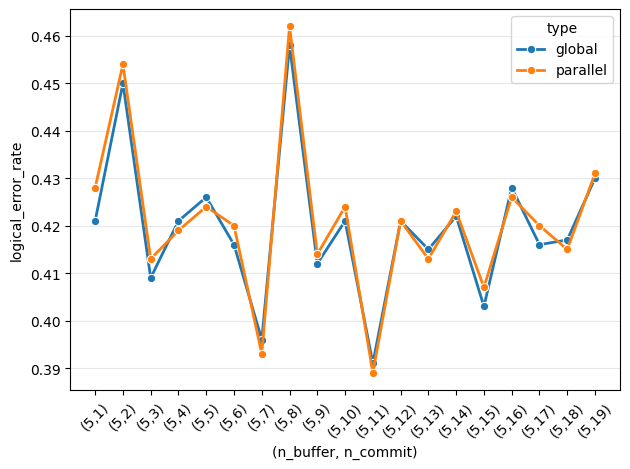

In [10]:
plot_ler_by_window(df)

In [28]:
d2c = dem.get_detector_coordinates()

nx.set_node_attributes(
    G,
    {i: {"pos": (d2c[i][0], d2c[i][1]), "kind":"detector", "defect":False} for i in range(dem.num_detectors)}
)

single_dets = [
    ins.targets_copy()[0].val for ins in dem 
    if ins.type == "error" and len(ins.targets_copy()) == 1
    ]

boundary_positions = [(d2c[d][0], d2c[d][1] + 1) for d in single_dets]


# Boundary nodes can be tuple keys (still hashable & serializable)
for k, (bx, by) in enumerate(boundary_positions):
    b = ("B", k)
    G.add_node(b, pos=(bx, by), kind="boundary")

boundary_positions

[(7.0, 1.0), (7.0, 3.0), (7.0, 5.0), (7.0, 7.0), (7.0, 9.0)]

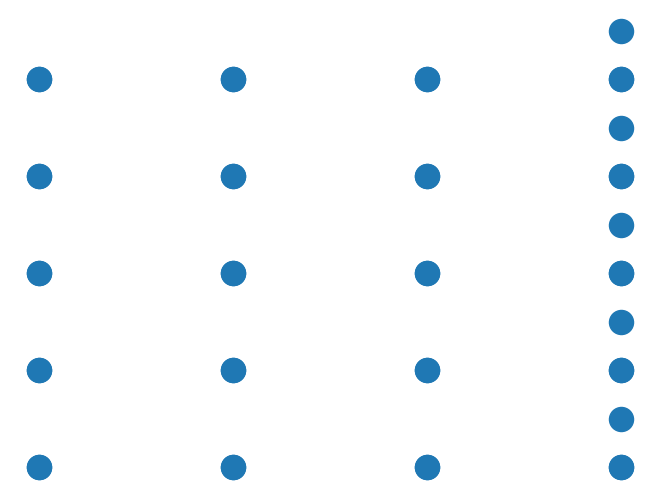

In [29]:
pos = nx.get_node_attributes(G, "pos")
nx.draw(G, pos)